# CSCI 4622 Final Project 

### By John Danekind and Daniel Hatakeyama

## Imports Necessary Libraries

In [11]:
# ---------- Import Essential Libraries ---------- #

# Machine Learning Essentials #
#import kaggle  uncomment if running locally


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model 
import cv2

# import splitfolders 
import pathlib
from pathlib import Path

# Python Utils #
import copy


## If running on local machine, use Kaggle API with the code in the cell below to get the right directory structure

In [2]:
# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('preetviradiya/brian-tumor-dataset', path='data', unzip=True)
# kaggle.api.dataset_metadata('preetviradiya/brian-tumor-dataset', path='.')

## Inputs and Folders

In [3]:
# Globals / Settings
KAGGLE_INPUT   = '/kaggle/input'
DATA_METADATA  = '/kaggle/input/brian-tumor-dataset/metadata.csv'
DATA_DIRECTORY = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set'


# Run cell below if working in Kaggle
## Read in data and make a dataframe with the filepaths and labels associated with said file path


In [4]:
# Define the directories and labels for both folders of images 

directories = {
    "Brain Tumor": '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
    "Healthy":  '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
}

# Create list of filepaths and a list of labels 
filepaths = []
labels = [] 

# Iterate through the directories and collect the file paths and labels 
for label, path in directories.items():
    for name in os.listdir(path):
        filepaths.append(os.path.join(path, name))
        labels.append(label)


# Create a dataframe with the file paths and the labels 

df = pd.DataFrame({"filepaths": filepaths, "labels": labels})




In [5]:
test_filepaths = filepaths[2]
print(f"test_filepaths: {test_filepaths}\n")

test_labels = labels[2:20]
print(f"test_labels: {test_labels}\n")

test_filepaths: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2411).jpg

test_labels: ['Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor']



# Run cell below if working locally 
## Note this requires the Kaggle API to get the directory structure required

In [12]:
# Define the directories and labels for both folders of images 

directories = {
  "Brain Tumor":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
  "Healthy":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
}
# Check if Files Exist
print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'))
print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'))

# Create list of filepaths and a list of labels 
filepaths = []
labels = [] 

# Iterate through the directories and collect the file paths and labels 
for label, path in directories.items():
  for name in os.listdir(path):
    filepaths.append(os.path.join(path, name))
    labels.append(label)


# Create a dataframe with the file paths and the labels 

df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

True
True


In [13]:
df.head()

class_counts = df['labels'].value_counts()
print(class_counts)

labels
Brain Tumor    2513
Healthy        2087
Name: count, dtype: int64


## Split data into training, testing, and validation sets

In [14]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=43,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=43,stratify=train_df.labels)

print(f"Training set is of shape {train_df.shape}")
print(f"Testing set is of shape {test_df.shape}")
print(f"Validation set is of shape {val_df.shape}")



Training set is of shape (2737, 2)
Testing set is of shape (1380, 2)
Validation set is of shape (483, 2)


# Preprocess Images 

# Data Generators (Batching, Data Augmentation, On-the-fly-processing, and flow control) 

In [15]:
# Use tensorflows ImageDataGenerator to preprocess the images 

# rescale parameter will scale pixel values to the range [0,1] 
image_generator = ImageDataGenerator(
    rescale=1./255 # Normalize image pixel values from [0,255] to [0,1]
)

# Create a data generator for the training set
train = image_generator.flow_from_dataframe(
    dataframe=train_df,         # DataFrame containing file paths and labels for training data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format (3 color channels)
    class_mode="categorical",   # Generate one-hot encoded labels for multi-class classification
    batch_size=64,              # Number of images to generate per batch
    shuffle=True               # Shuffle images 
)

# Create a data generator for the test set
test = image_generator.flow_from_dataframe(
    dataframe=test_df,          # DataFrame containing file paths and labels for test data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for evaluation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for testing
)

# Create a data generator for the validation set
val = image_generator.flow_from_dataframe(
    dataframe=val_df,           # DataFrame containing file paths and labels for validation data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for validation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for validation
)


Found 2737 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 483 validated image filenames belonging to 2 classes.


# Examples from dataset



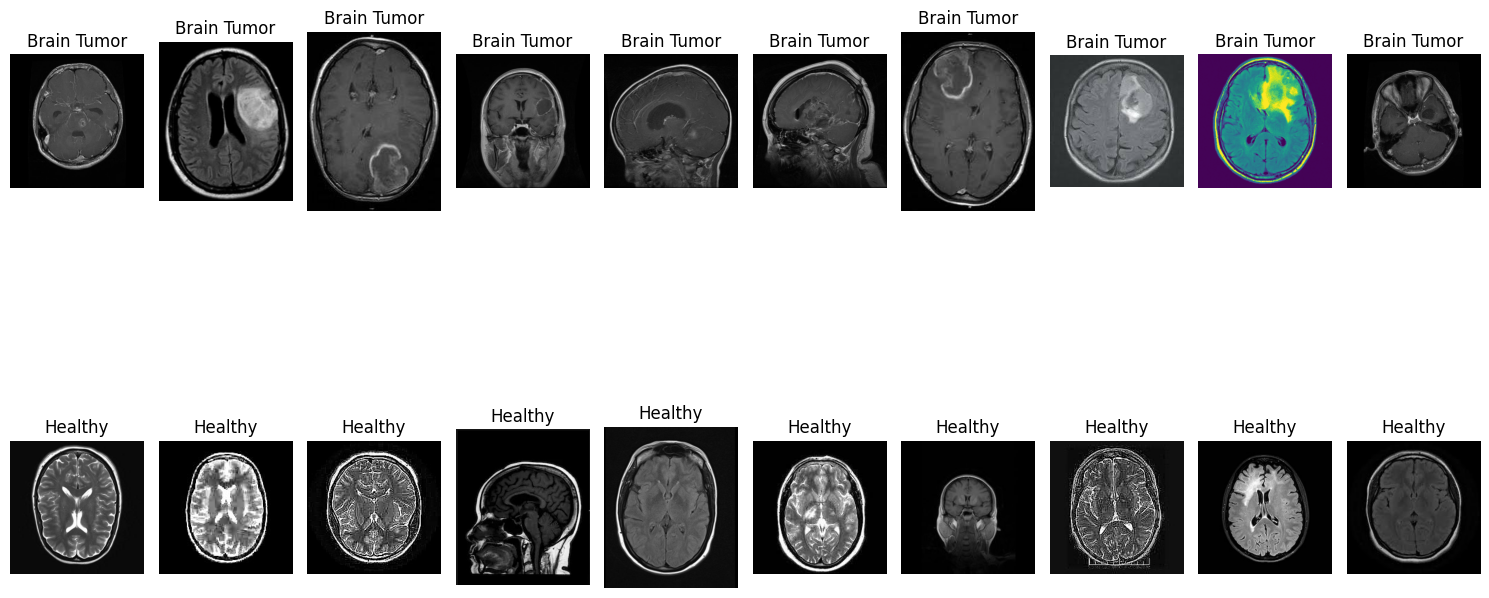

In [16]:
# Arbritrary number of images from each class in the dataset 
images_per_class = 10

# Get class labels
class_labels = train.class_indices.keys()

# Initialize plot 
plt.figure(figsize=(15, 10))

# Plot images for each class
for label_index, label in enumerate(class_labels):
    # Get the filepaths of the current class 
    filepaths = train_df.loc[train_df['labels'] == label, 'filepaths']
    
    # Randomly select images to display
    selected_filepaths = np.random.choice(filepaths, min(images_per_class, len(filepaths)), replace=False)
    
    # Plot the images
    for i, filepath in enumerate(selected_filepaths):
        plt_idx = label_index * images_per_class + i + 1
        plt.subplot(len(class_labels), images_per_class, plt_idx)
        plt.imshow(plt.imread(filepath))
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()


# Create CNN and Compile the Model 

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
# Using a sequential model with 3 convolutional layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # First Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(64, (3, 3), activation='relu'),                              # Second Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(128, (3, 3), activation='relu'),                             # Third Conv Layer
    MaxPooling2D((2, 2)),                                               # Max pooling 
    Flatten(),                                                          # Flatten the output
    Dense(128, activation='relu'),                                      # Fully Connected Layer
    Dropout(0.5),                                                       # Dropout for regularization
    Dense(len(train.class_indices), activation='softmax')               # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',   # Since it's multi-class classification
    metrics=['accuracy']
)

# Summary of the model architecture
model.summary()


/Users/john/CU_Boulder/Semesters/Fall_2024/Machine Learning/Project/Brain_Tumor_Classifcation_Grad_Cam/brain-tumor-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [18]:
# Train the model
history = model.fit(
    train,                           # Training data
    epochs=15,                        # Number of epochs
    validation_data=val,              # Validation data
    steps_per_epoch=train.samples // train.batch_size,    # Steps per epoch
    validation_steps=val.samples // val.batch_size,        # Validation steps
    verbose=1
)

# Save the trained model (optional)
model.save('cnn_model.h5')


Epoch 1/15


/Users/john/CU_Boulder/Semesters/Fall_2024/Machine Learning/Project/Brain_Tumor_Classifcation_Grad_Cam/brain-tumor-env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6483 - loss: 0.8645 - val_accuracy: 0.7835 - val_loss: 0.5158
Epoch 2/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7500 - loss: 0.5370

/Users/john/CU_Boulder/Semesters/Fall_2024/Machine Learning/Project/Brain_Tumor_Classifcation_Grad_Cam/brain-tumor-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7500 - loss: 0.5370 - val_accuracy: 0.7812 - val_loss: 0.5112
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8096 - loss: 0.4281 - val_accuracy: 0.8371 - val_loss: 0.3823
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8438 - loss: 0.3340 - val_accuracy: 0.8415 - val_loss: 0.3744
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 955ms/step - accuracy: 0.8773 - loss: 0.3053 - val_accuracy: 0.8772 - val_loss: 0.2823
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8906 - loss: 0.2701 - val_accuracy: 0.8973 - val_loss: 0.2702
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 981ms/step - accuracy: 0.9222 - loss: 0.2069 - val_accuracy: 0.9196 - val_loss: 0.2056
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9219 - loss: 0.1675 - val_accuracy: 0.9196 - val_loss: 0.2055
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 964ms/step - accuracy: 0.9424 - loss: 0.1644 - val_accuracy: 0.9330 - val_los

In [19]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9326 - loss: 0.2835
Test Loss: 0.2835339605808258
Test Accuracy: 0.9326087236404419


## Create plots of training and validation accuracy as a fucntion of the number of Epochs as well as training and validation as a function of the number of epochs

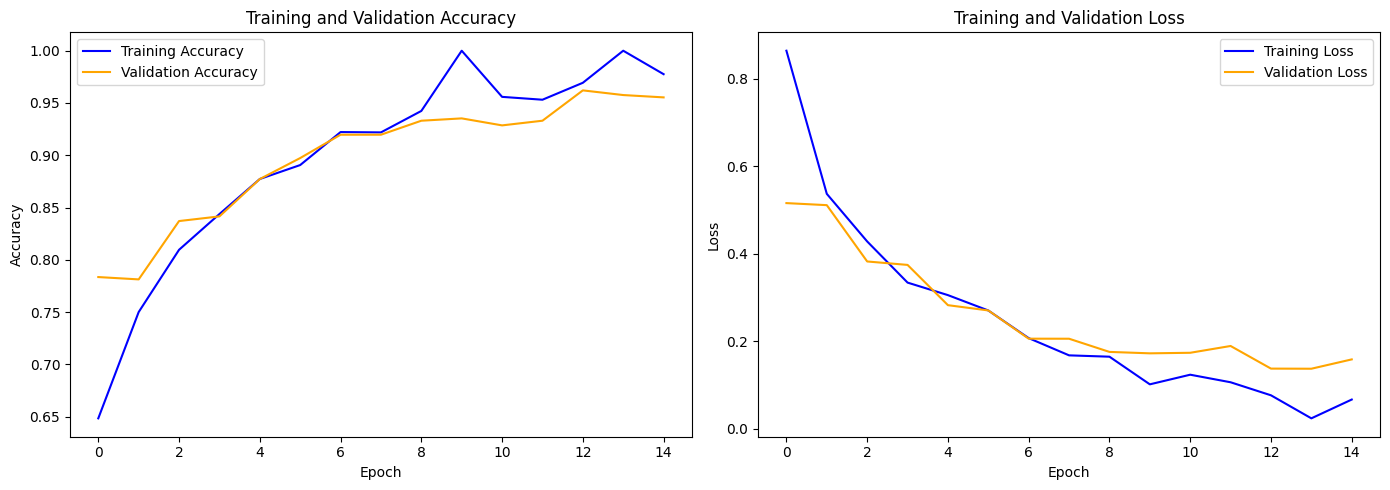

In [20]:
# Retrieve accuracy and loss data from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step


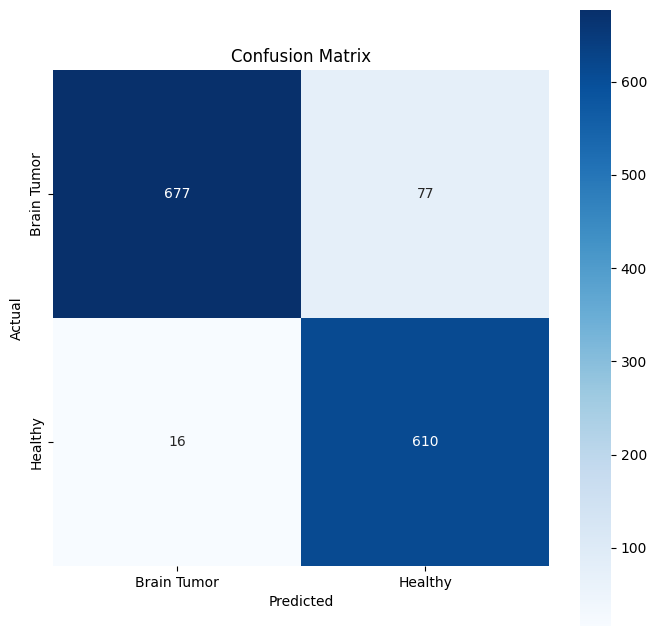

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Dicussion: 
With 3 convolutinal layers, the model is around 96-97% accurate on the test data after 15 epochs.

## Grad_Cam

Found 2737 validated image filenames belonging to 2 classes.
Selected Label (one-hot encoded): [0. 1.]
Decoded Label: healthy
Image Index: 0
Image Size: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Preds: [[ 7.8351274 -9.161631 ]]
Predicted: cancer


/Users/john/CU_Boulder/Semesters/Fall_2024/Machine Learning/Project/Brain_Tumor_Classifcation_Grad_Cam/brain-tumor-env/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


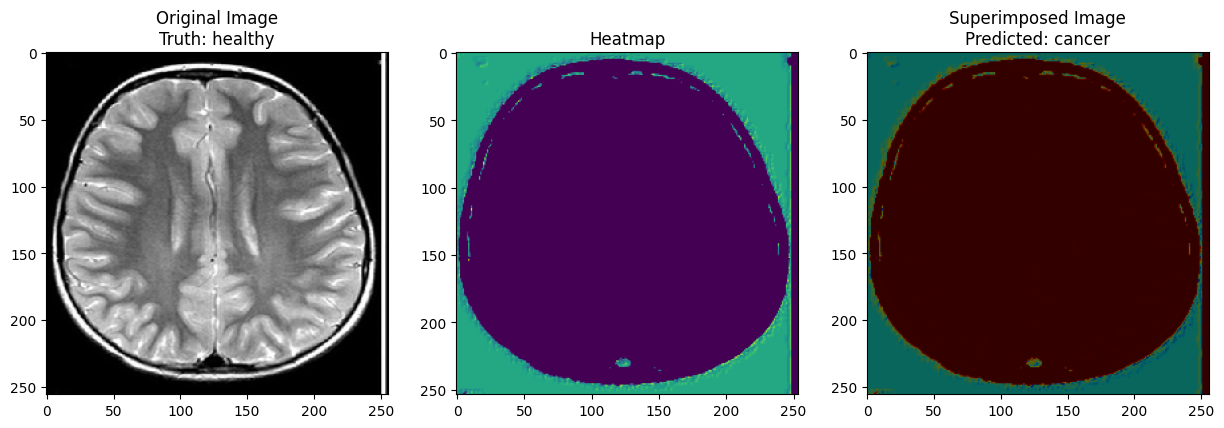

Selected Label (one-hot encoded): [0. 1.]
Decoded Label: healthy
Image Index: 0
Image Size: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Preds: [[-17.272924    7.6207833]]
Predicted: healthy


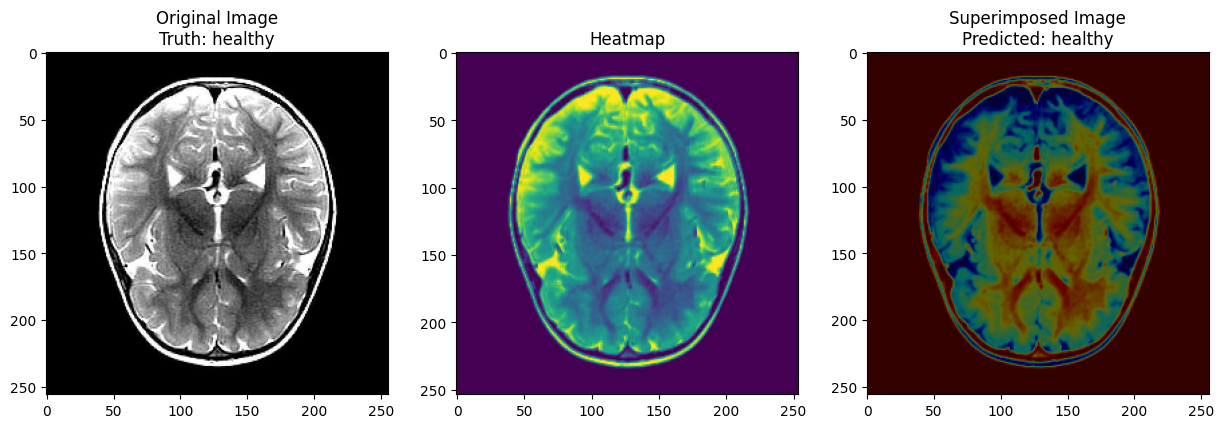

Selected Label (one-hot encoded): [1. 0.]
Decoded Label: cancer
Image Index: 0
Image Size: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Preds: [[ 3.1399994 -8.109926 ]]
Predicted: cancer


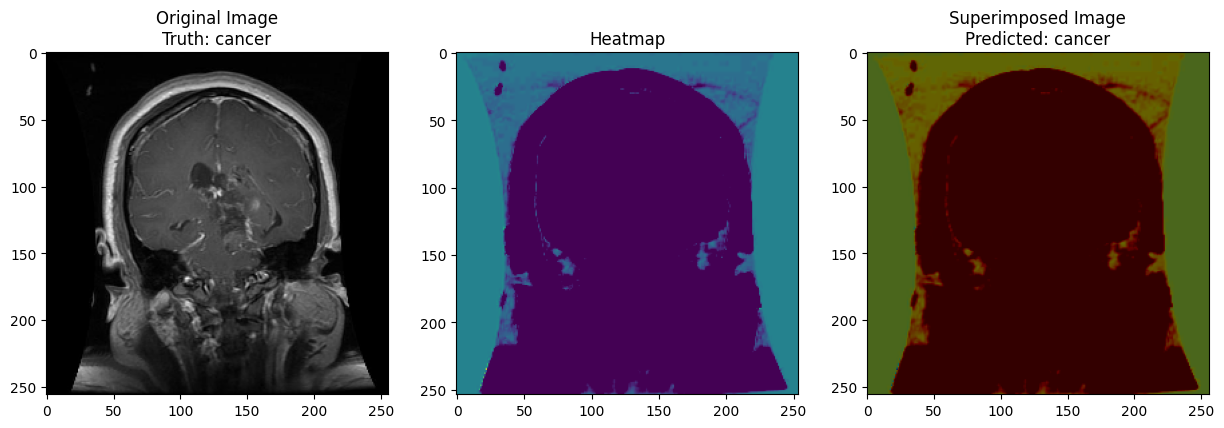

Selected Label (one-hot encoded): [1. 0.]
Decoded Label: cancer
Image Index: 0
Image Size: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Preds: [[ 7.409536  -2.7801697]]
Predicted: cancer


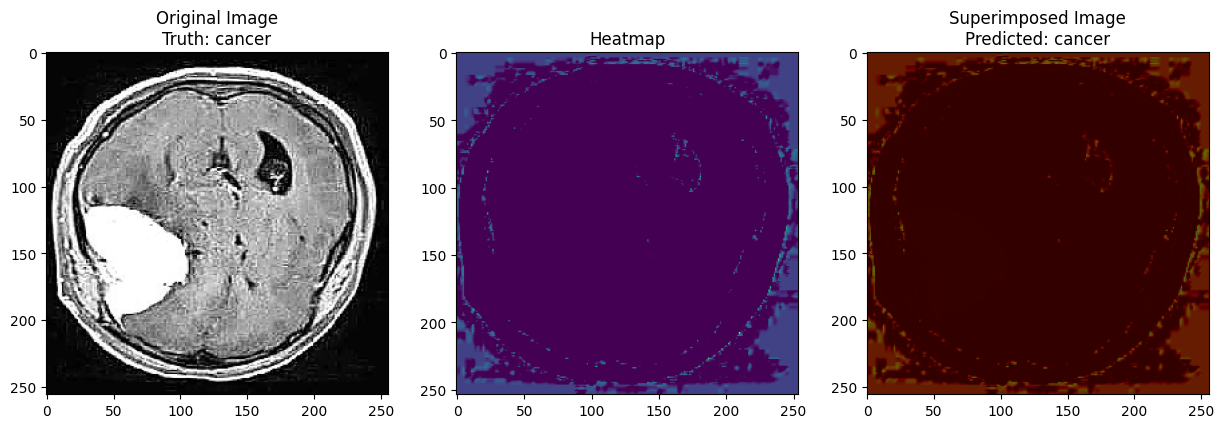

Selected Label (one-hot encoded): [1. 0.]
Decoded Label: cancer
Image Index: 0
Image Size: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Preds: [[ 0.88755727 -5.398764  ]]
Predicted: cancer


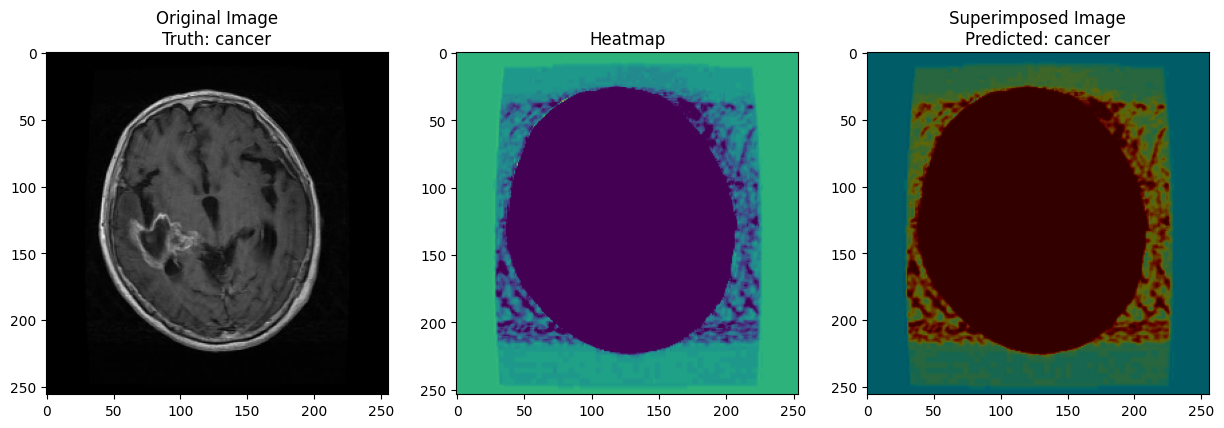

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# Custom decode function
def custom_decode_predictions(preds, top=1):
    class_labels = ['cancer', 'healthy']  # Class labels 
    top_indices = preds[0].argsort()[-top:][::-1]
    result = [(class_labels[i], preds[0][i]) for i in top_indices]
    return result

# Function to get image array
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Get the classifier part of the model
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer)+1:]:
        x = layer(x)
    classifier_model = keras.Model(classifier_input, x)

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to superimpose heatmap on image
def superimpose_heatmap(img, heatmap, alpha=0.4):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Create a data generator for the training set
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train = image_generator.flow_from_dataframe(
    dataframe=train_df,         # DataFrame containing file paths and labels for training data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format (3 color channels)
    class_mode="categorical",   # Generate one-hot encoded labels for multi-class classification
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order of images in this generator
)


# TODO refactor this later into a fuction that takes in index, dataflow(test train etc), then run for loop on the function calls
for i in range(5):

    # Get a batch of images and labels
    images, labels = next(test)
    
    # Select an image index within the batch
    image_idx = 0
    selected_image = images[image_idx]  # Preprocessed image
    selected_label = labels[image_idx]  # Corresponding label (one-hot encoded)

    # Print the selected label
    print(f"Selected Label (one-hot encoded): {selected_label}")
    
    # Decode the selected label using the custom decode function
    decoded_label = custom_decode_predictions([selected_label])
    print(f"Decoded Label: {decoded_label[0][0]}")
    
    # Add a batch dimension for Grad-CAM calculations
    preprocessed_image = np.expand_dims(selected_image, axis=0)  # Shape: (1, 256, 256, 3)
    
    print(f"Image Index: {image_idx}")
    print(f"Image Size: {selected_image.shape}")
    
    # Prepare image for Grad-CAM
    img_array = preprocessed_image
    
    # Remove last layer's softmax
    model.layers[-1].activation = None
    
    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Preds:",preds)
    predicted = custom_decode_predictions(preds, top=1)[0][0]
    print("Predicted:", predicted)
    
    # Generate class activation heatmap
    last_conv_layer_name = "conv2d_3"  # Will need to change if you run the model multiple times
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # Superimpose heatmap on image
    superimposed_img = superimpose_heatmap(selected_image, heatmap)
    
    # Display the selected preprocessed image, heatmap, and superimposed image side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(selected_image)
    axes[0].set_title(f"Original Image\nTruth: {decoded_label[0][0]}")
    #axes[0].axis("off")
    
    axes[1].imshow(heatmap)
    axes[1].set_title("Heatmap")
    #axes[1].axis("off")
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title(f"Superimposed Image\nPredicted: {predicted}")
    #axes[2].axis("off")
    
    plt.show()